https://github.com/Thinkful-Ed/data-201-assignment-solutions/blob/master/model_prep_feature_engineering_1/solution.ipynb

```
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'youtube'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

youtube_df = pd.read_sql_query('select * from youtube',con=engine)

# No need for an open connection, 
# because you're only doing a single query
engine.dispose()

# You're dealing with the missing values

youtube_df["Video Uploads"] = youtube_df["Video Uploads"].apply(str.strip).replace("--", np.nan)
youtube_df["Video Uploads"] = pd.to_numeric(youtube_df["Video Uploads"], downcast="float")

youtube_df["Subscribers"] = youtube_df["Subscribers"].apply(str.strip).replace("--", np.nan)
youtube_df["Subscribers"] = pd.to_numeric(youtube_df["Subscribers"], downcast="float")

youtube_df.Grade = youtube_df.Grade.apply(str.strip).replace("", np.nan)


youtube_df["Video Uploads"].fillna(youtube_df["Video Uploads"].mean(), inplace=True)
youtube_df["Subscribers"].fillna(youtube_df["Subscribers"].mean(), inplace=True)


# Apply one-way winsorization to the highest end
# of the value distribution. Because you have a lot of extreme
# values, set the values of the outliers to the 
# value of the ninetieth percentile. 
youtube_df["winsorized_uploads"] = winsorize(youtube_df["Video Uploads"], (0, 0.10))
youtube_df["winsorized_subscribers"] = winsorize(youtube_df["Subscribers"], (0, 0.10))
youtube_df["winsorized_views"] = winsorize(youtube_df["Video views"], (0, 0.10))

for i in range(0, len(youtube_df.Grade)):
    if pd.isnull(youtube_df.Grade[i]):
        youtube_df.Grade[i] = youtube_df.Grade[i-1]
        
```

```
#Get dummy variables for categorical vars

# One-hot encoding the `Grade` variable: 
pd.get_dummies(youtube_df["Grade"])
```

```
# Append dummies to the YouTube DataFrame
youtube_df = pd.concat([youtube_df, pd.get_dummies(youtube_df["Grade"])], axis=1)
youtube_df
```

```
# Check normality with norm test and jb 

from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(np.log(youtube_df["Subscribers"]))
norm_stats = normaltest(np.log(youtube_df["Subscribers"]))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(np.log(youtube_df["Video Uploads"]))
norm_stats = normaltest(np.log(youtube_df["Video Uploads"]))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(np.log(youtube_df["Video views"]))
norm_stats = normaltest(np.log(youtube_df["Video views"]))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))
```

```
# Box Cox Transformataion

from scipy.stats import boxcox

video_uploads_boxcox,_ = boxcox(youtube_df["Video Uploads"])
subscribers_boxcox,_ = boxcox(youtube_df["Subscribers"])
video_views_boxcox,_ = boxcox(youtube_df["Video views"])

plt.figure(figsize=(18,5))

# Histograms of the Box-Cox-transformed data
plt.subplot(1, 3, 1)
plt.hist(subscribers_boxcox)
plt.title("histogram of subscribers (box-cox transformed)")

plt.subplot(1, 3, 2)
plt.hist(video_uploads_boxcox)
plt.title("histogram of video uploads (box-cox transformed)")

plt.subplot(1, 3, 3)
plt.hist(video_views_boxcox)
plt.title("histogram of video views (box-cox transformed)")

plt.show()
```

```
# normalize --> [0,1] (inclusive)

from sklearn.preprocessing import normalize

# Normalize the winsorized variables
youtube_df["norm_winsorized_subscribers"] = normalize(np.array(youtube_df["winsorized_subscribers"]).reshape(1,-1)).reshape(-1,1)
youtube_df["norm_winsorized_views"] = normalize(np.array(youtube_df["winsorized_views"]).reshape(1,-1)).reshape(-1,1)
youtube_df["norm_winsorized_uploads"] = normalize(np.array(youtube_df["winsorized_uploads"]).reshape(1,-1)).reshape(-1,1)

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
# Draw the scatter plot using seaborn
plt.scatter(youtube_df["winsorized_subscribers"], youtube_df["norm_winsorized_subscribers"])
plt.title("scatterplot of original and normalized values (Subscribers)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (normalized)")

plt.subplot(1,3,2)
# Draw the scatter plot using seaborn
plt.scatter(youtube_df["winsorized_views"], youtube_df["norm_winsorized_views"])
plt.title("scatterplot of original and normalized values (Video views)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (normalized)")

plt.subplot(1,3,3)
# Draw the scatter plot using seaborn
plt.scatter(youtube_df["winsorized_uploads"], youtube_df["norm_winsorized_uploads"])
plt.title("scatterplot of original and normalized values (Video uploads)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (normalized)")

plt.show()
```

```
#Standardize 


from sklearn.preprocessing import scale

youtube_df["scaled_winsorized_subscribers"] = scale(youtube_df["winsorized_subscribers"])
youtube_df["scaled_winsorized_views"] = scale(youtube_df["winsorized_views"])
youtube_df["scaled_winsorized_uploads"] = scale(youtube_df["winsorized_uploads"])

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
# Draw the scatter plot using seaborn
plt.scatter(youtube_df["winsorized_subscribers"], youtube_df["scaled_winsorized_subscribers"])
plt.title("scatterplot of original and standardized values (Subscribers)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (standardized)")
plt.xlim(0.00000001)

plt.subplot(1,3,2)
# Draw the scatter plot using seaborn
plt.scatter(youtube_df["winsorized_views"], youtube_df["scaled_winsorized_views"])
plt.title("scatterplot of original and standardized values (Video views)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (standardized)")

plt.subplot(1,3,3)
# Draw the scatter plot using seaborn
plt.scatter(youtube_df["winsorized_uploads"], youtube_df["scaled_winsorized_uploads"])
plt.title("scatterplot of original and standardized values (Video uploads)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (standardized)")

plt.show()
```

```
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
from scipy.stats.stats import ttest_ind
import warnings
```

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox
import matplotlib.pyplot as plt

In [ ]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

In [ ]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

student_df = pd.read_sql_query('select * from studentsperformance',con=engine)

# No need for an open connection, 
# because you're only doing a single query
engine.dispose()

In [ ]:
student_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


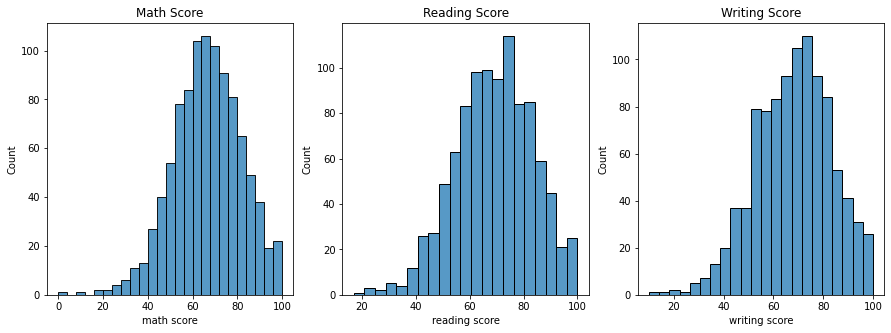

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)
plt.subplot(1,3,1)
ax0 = sns.histplot(student_df["math score"])
ax0.set_title('Math Score')
plt.subplot(1,3,2)
ax1 = sns.histplot(student_df["reading score"])
ax1.set_title('Reading Score')
plt.subplot(1,3,3)
ax2 = sns.histplot(student_df['writing score'])
ax2.set_title('Writing Score')
plt.show()

```
jb_stats = jarque_bera(np.log(youtube_df["Subscribers"]))
norm_stats = normaltest(np.log(youtube_df["Subscribers"]))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))
```

In [ ]:
jb_stats = jarque_bera(student_df['math score'])
norm_stats = normaltest(student_df['math score'])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 15.912256686712709 and p value is 0.0003505075386818213
Normality test statistics is 15.408960513931822 and p value is 0.00045080293869937836


In [ ]:
jb_stats = jarque_bera(student_df['reading score'])
norm_stats = normaltest(student_df['reading score'])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 11.383300575987892 and p value is 0.0033740202672214448
Normality test statistics is 11.11741279628622 and p value is 0.003853758403576582


In [ ]:
jb_stats = jarque_bera(student_df['writing score'])
norm_stats = normaltest(student_df['writing score'])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 13.98509448257235 and p value is 0.0009187033894586527
Normality test statistics is 13.606450837263859 and p value is 0.0011101885439899974


We reject normality for all scores

Apply Box-Cox transformation

In [ ]:
# Find non positive entries

student_df[student_df["math score"] == 0]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
59,female,group C,some high school,free/reduced,none,0,17,10


In [ ]:
student_df[student_df["reading score"] == 0]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score


In [ ]:
student_df[student_df["writing score"] == 0]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score


In [ ]:
# Remove non positive scores
student2_df = student_df[student_df["math score"] != 0]

In [ ]:
math_boxcox,_ = boxcox(student2_df["math score"])
reading_boxcox,_ = boxcox(student2_df["reading score"])
writing_boxcox,_ = boxcox(student2_df["writing score"])

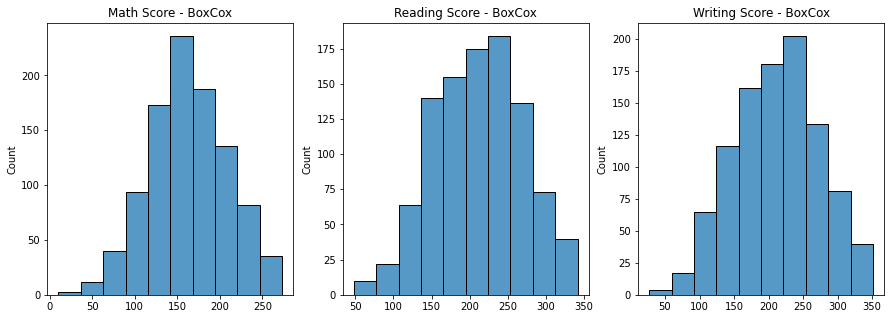

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)
plt.subplot(1,3,1)
ax0 = sns.histplot(math_boxcox, bins=10)
ax0.set_title('Math Score - BoxCox')
plt.subplot(1,3,2)
ax1 = sns.histplot(reading_boxcox, bins=10)
ax1.set_title('Reading Score - BoxCox')
plt.subplot(1,3,3)
ax2 = sns.histplot(writing_boxcox, bins=10)
ax2.set_title('Writing Score - BoxCox')
plt.show()

In [ ]:
jb_stats = jarque_bera(math_boxcox)
norm_stats = normaltest(math_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 1.7200982636836308 and p value is 0.42314129209599327
Normality test statistics is 1.8323075851586939 and p value is 0.4000547794685686


In [ ]:
jb_stats = jarque_bera(reading_boxcox)
norm_stats = normaltest(reading_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 4.8891540799411395 and p value is 0.08676282434883942
Normality test statistics is 6.546500254297637 and p value is 0.03788310187455936


In [ ]:
jb_stats = jarque_bera(writing_boxcox)
norm_stats = normaltest(writing_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 5.762346713079429 and p value is 0.05606893537015201
Normality test statistics is 8.018367650263817 and p value is 0.018148201299612785


1. Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?

No, all scores are not normally distributed. Yes, after applying the Box-Cox transformation there was a change.

- math score: 
  - failed to reject normality, check
- reading score:
  - failed to reject for Jarque-Bera at $\alpha = 0.05$, check
  - rejected for normal test at $\alpha = 0.05$, no check
- writing score:
  - failed to reject for Jarque-Bera at $\alpha = 0.05$, check
  - rejected for normal test at $\alpha = 0.05$, no check

In [ ]:
# Create single variable by taking weighted average of exam scores
student2_df['avg score'] = student2_df[['math score', 'reading score', 'writing score']].mean(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Another way to create single var
student2_df.loc[:,'avg score2'] = student2_df.loc[:,['math score', 'reading score', 'writing score']].mean(axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


```
# Another way

exam_score = (education_df["math score"] +
              education_df["reading score"] + education_df["writing score"])/3
```

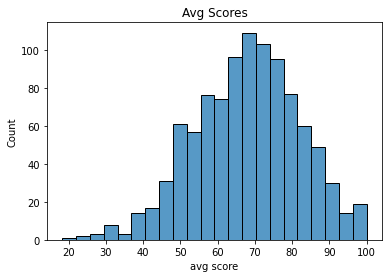

In [ ]:
ax = sns.histplot(student2_df['avg score'])
ax.set_title('Avg Scores')
plt.show()

In [ ]:
# Check for Normality for Avg Scores
jb_stats = jarque_bera(student2_df['avg score'])
norm_stats = normaltest(student2_df['avg score'])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 10.345394363749879 and p value is 0.0056692571616785425
Normality test statistics is 10.127189207749474 and p value is 0.006322790687068094


Reject Normality. Will apply Box-Cox Transformation to avg. acores

In [ ]:
avg_boxcox,_ = boxcox(student2_df["avg score"])

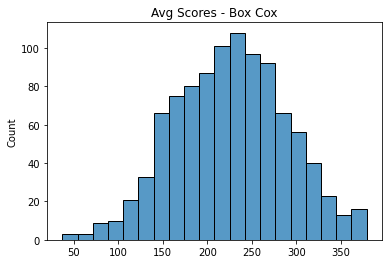

In [ ]:
ax = sns.histplot(avg_boxcox)
ax.set_title('Avg Scores - Box Cox')
plt.show()

In [ ]:
# Check for Normality for BoxCox Avg Scores
jb_stats = jarque_bera(avg_boxcox)
norm_stats = normaltest(avg_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3.4323846909111793 and p value is 0.17974926966382276
Normality test statistics is 4.219879978703656 and p value is 0.12124524222064059


2. Say you want to use a single variable for the exam scores as your target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.
---
The new single variable that is the weighted average of scores, `avg score`, is not normally distributed. After applying the Box-Cox transformation, the transformation is normally distributed at an $\alpha = 0.05$ significance level.

In [ ]:
student2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       999 non-null    object 
 1   race/ethnicity               999 non-null    object 
 2   parental level of education  999 non-null    object 
 3   lunch                        999 non-null    object 
 4   test preparation course      999 non-null    object 
 5   math score                   999 non-null    int64  
 6   reading score                999 non-null    int64  
 7   writing score                999 non-null    int64  
 8   avg score                    999 non-null    float64
 9   avg score2                   999 non-null    float64
dtypes: float64(2), int64(3), object(5)
memory usage: 85.9+ KB


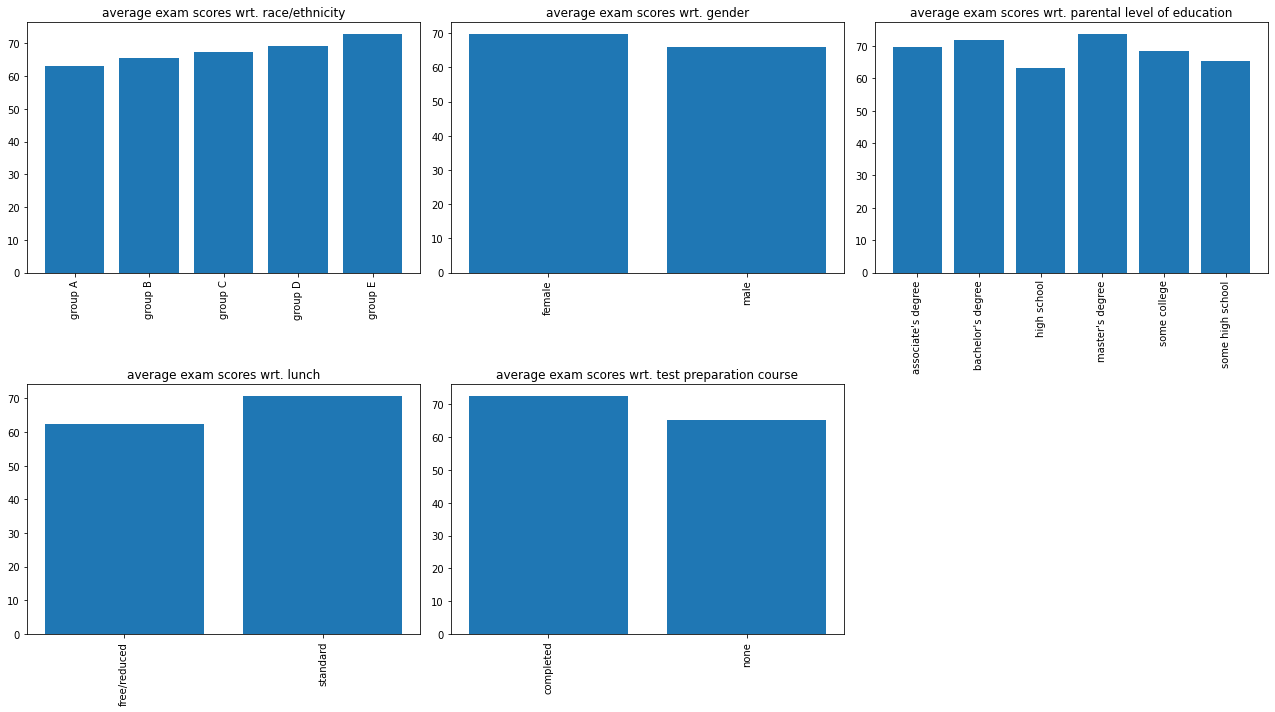

In [ ]:
#education_df["avg score"] = exam_score

plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.bar(student2_df.groupby("race/ethnicity")
        ["avg score"].mean().index, student2_df.groupby("race/ethnicity")["avg score"].mean())

plt.title("average exam scores wrt. race/ethnicity")
plt.xticks(rotation="vertical")

plt.subplot(2, 3, 2)
plt.bar(student2_df.groupby("gender")
        ["avg score"].mean().index, student2_df.groupby("gender")["avg score"].mean())

plt.title("average exam scores wrt. gender")
plt.xticks(rotation="vertical")

plt.subplot(2, 3, 3)
plt.bar(student2_df.groupby("parental level of education")
        ["avg score"].mean().index, student2_df.groupby("parental level of education")["avg score"].mean())

plt.title("average exam scores wrt. parental level of education")
plt.xticks(rotation="vertical")

plt.subplot(2, 3, 4)
plt.bar(student2_df.groupby("lunch")
        ["avg score"].mean().index, student2_df.groupby("lunch")["avg score"].mean())

plt.title("average exam scores wrt. lunch")
plt.xticks(rotation="vertical")

plt.subplot(2, 3, 5)
plt.bar(student2_df.groupby("test preparation course")
        ["avg score"].mean().index, student2_df.groupby("test preparation course")["avg score"].mean())

plt.title("average exam scores wrt. test preparation course")
plt.xticks(rotation="vertical")

plt.tight_layout()
plt.show()

3. Which variables seem related to the target variable (the newly created variable from the previous question)? If your goal is to explain the determinants of success in exams, which variables in your dataset might be useful?
---


1. Average exam score increases from group A to group E. Hence race/ethnicity may play an important role in explaining the successes in the exams.

2. Female students seem to be more successful than the males.

3. There is also some variation between the parental levels of education with respect to the exam scores.

4. Lunch type also exhibits variance in the average exam scores. But, this is probably not because of the lunch type itself but because of something that affects both the lunch type and the exam scores.

5. Those who completed the test preparation course seem to be more successful than the others.

Considering all these, all variables might be used in explaining the success in the exams but the lunch variable should be used precautiously.